In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import math

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy.optimize import leastsq

from sklearn import linear_model
from numpy.linalg import norm

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

import random
random.seed(10)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
num_round = 20
distance_sq = [None] * num_round
distance_trf = [None] * num_round
distance_lm = [None] * num_round

In [3]:
for k in range (num_round):
    random.seed(10)
    true_para = np.array([0.31, -0.6, 0.29, -0.01, 0.011, 0.009, -0.01, -0.012, 0.015, 0.3, 0.5, 0.2, 100])
    #true_para = np.array([0.21, -0.4, 0.19, -0.02, 0.016, 0.01, -0.014, -0.017, 0.02, 0.3, 0.5, 0.2, 100])
    time_seg = 0.4
    cur_time = np.arange(0, 20+time_seg, time_seg)
    num_point = len(cur_time)
    num_iteration = 100
    n0_est = 200
    
    # define the right hand side of the ODE equations in the Scipy odeint signature
    from numba import njit


    @njit
    def rhs(X, t, theta):
        # unpack parameters
        x, y, z, n = X
        r1, r2, r3, b12, b13, b21, b23, b31, b32, x0, y0, z0, n0 = theta
        # equations
        dn_dt = r1*x*n + b12*x*y*n*n + b13*x*z*n*n + r2*y*n + b21*x*y*n*n + b23*y*z*n*n + r3*z*n + b31*x*z*n*n + b32*y*z*n*n
        dx_dt = (r1*x*n + b12*x*y*n*n + b13*x*z*n*n - x*dn_dt)/n
        dy_dt = (r2*y*n + b21*x*y*n*n + b23*y*z*n*n - y*dn_dt)/n
        dz_dt = (r3*z*n + b31*x*z*n*n + b32*y*z*n*n - z*dn_dt)/n
        return [dx_dt, dy_dt, dz_dt, dn_dt]
    
    # note theta = alpha, beta, gamma, delta, xt0, yt0
    theta = true_para
    time = cur_time

    # call Scipy's odeint function, 
    x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    
    data = pd.DataFrame(dict(
    n1_relative = np.array(x_y[:, 0]),
    n2_relative = np.array(x_y[:, 1]),
    n3_relative = np.array(x_y[:, 2]),
    absolute_sum = np.array(x_y[:, 3]),
    n1_abs = np.array(x_y[:, 0]) * n0_est,
    n2_abs = np.array(x_y[:, 1]) * n0_est,
    n3_abs = np.array(x_y[:, 2]) * n0_est, 
    n1_true = np.array(x_y[:, 0]) * np.array(x_y[:, 3]),
    n2_true = np.array(x_y[:, 1]) * np.array(x_y[:, 3]),
    n3_true = np.array(x_y[:, 2]) * np.array(x_y[:, 3]), 
    ))
    
    for i in range (num_point-1):
        data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])
    
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r1_ini = regr.intercept_[0]
    b12_ini = regr.coef_[0,0]
    b13_ini = regr.coef_[0,1]
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r2_ini = regr.intercept_[0]
    b21_ini = regr.coef_[0,0]
    b23_ini = regr.coef_[0,1]
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r3_ini = regr.intercept_[0]
    b31_ini = regr.coef_[0,0]
    b32_ini = regr.coef_[0,1]
    
    theta_estimate = np.array([r1_ini, r2_ini, r3_ini, b12_ini, b13_ini, b21_ini, b23_ini, b31_ini, b32_ini, true_para[-4], true_para[-3], true_para[-2], n0_est])
    
    
    theta = theta_estimate

    time = cur_time

     # call Scipy's odeint function, 
    x_y_hat = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    data = pd.DataFrame(dict(
        n1_relative = np.array(x_y_hat[:, 0]),
        n2_relative = np.array(x_y_hat[:, 1]),
        n3_relative = np.array(x_y_hat[:, 2]),
        absolute_sum = np.array(x_y_hat[:, 3]),
        n1_abs = np.array(x_y[:, 0]) * np.array(x_y_hat[:, 3]),
        n2_abs = np.array(x_y[:, 1]) * np.array(x_y_hat[:, 3]),
        n3_abs = np.array(x_y[:, 2]) * np.array(x_y_hat[:, 3]), 
    ))
    for i in range (num_point-1):
        data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i]) 
        
    theta = true_para
    time = cur_time

    # call Scipy's odeint function, 
    real_value = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    
    
    NM = num_iteration
    distance = [None] * NM
    distance_min = np.inf
    theta_min = theta_estimate

    for m in range(NM):
        theta = theta_estimate
        time = cur_time
        
        x_y_hat = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
        dis_one = (np.array(real_value[:, 0] - x_y_hat[:, 0]))**2
        dis_two = (np.array(real_value[:, 1] - x_y_hat[:, 1]))**2
        dis_three = (np.array(real_value[:, 2] - x_y_hat[:, 2]))**2
        distance[m] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
        
        if distance[m] < distance_min:
            distance_min = distance[m]
            theta_min = theta_estimate
    
        data = pd.DataFrame(dict(
            n1_relative = np.array(x_y_hat[:, 0]),
            n2_relative = np.array(x_y_hat[:, 1]),
            n3_relative = np.array(x_y_hat[:, 2]),
            absolute_sum = np.array(x_y_hat[:, 3]),
            n1_abs = np.array(x_y[:, 0]) * np.array(x_y_hat[:, 3]),
            n2_abs = np.array(x_y[:, 1]) * np.array(x_y_hat[:, 3]),
            n3_abs = np.array(x_y[:, 2]) * np.array(x_y_hat[:, 3]), 
    ))
        
        for i in range (num_point-1):
            data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])  
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        r1_hat = regr.intercept_[0]
        b12_hat = regr.coef_[0,0]
        b13_hat = regr.coef_[0,1]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        r2_hat = regr.intercept_[0]
        b21_hat = regr.coef_[0,0]
        b23_hat = regr.coef_[0,1]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        r3_hat = regr.intercept_[0]
        b31_hat = regr.coef_[0,0]
        b32_hat = regr.coef_[0,1]
    
        theta_estimate = np.array([r1_hat, r2_hat, r3_hat, b12_hat, b13_hat, b21_hat, b23_hat, b31_hat, b32_hat, true_para[-4], true_para[-3], true_para[-2], n0_est])
    
    theta = true_para
    time = cur_time

    x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))

    data = pd.DataFrame(dict(
        year = cur_time,
        n1_relative = np.array(x_y[:, 0]),
        n2_relative = np.array(x_y[:, 1]),
        n3_relative = np.array(x_y[:, 2]),
        absolute_sum = np.array(x_y[:, 3]),
        n1_abs = np.array(x_y[:, 0]) * np.array(x_y[:, 3]),
        n2_abs = np.array(x_y[:, 1]) * np.array(x_y[:, 3]),
        n3_abs = np.array(x_y[:, 2]) * np.array(x_y[:, 3]), 
    ))
    
    # function that calculates residuals based on a given theta
    def ode_model_resid(thetab):
        return (
            np.abs(data[["n1_relative", "n2_relative", "n3_relative"]] - np.delete(odeint(func=rhs, y0=thetab[-4:], t=time, args=(thetab,)), -1, axis=1))
        ).values.flatten()

    theta_est = theta_min
    random.seed(10)
    results = leastsq(ode_model_resid, x0=theta_est)
    
    theta = results[0]
    time = cur_time

    # call Scipy's odeint function0.015, 
    x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    
            
    dis_one = (np.array(real_value[:, 0] - x_y[:, 0]))**2
    dis_two = (np.array(real_value[:, 1] - x_y[:, 1]))**2
    dis_three = (np.array(real_value[:, 2] - x_y[:, 2]))**2
    distance_sq[k]= math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
    
    
    theta_est = theta_min
    random.seed(10)
    results = least_squares(ode_model_resid, x0=theta_est, method = 'trf')
    
    theta = results.x
    time = cur_time

    # call Scipy's odeint function0.015, 
    x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    
    dis_one = (np.array(real_value[:, 0] - x_y[:, 0]))**2
    dis_two = (np.array(real_value[:, 1] - x_y[:, 1]))**2
    dis_three = (np.array(real_value[:, 2] - x_y[:, 2]))**2
    distance_trf[k]= math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
    
    theta_est = theta_min
    random.seed(10)
    results = least_squares(ode_model_resid, x0=theta_est, method = 'lm')
    
    theta = results.x
    time = cur_time

    # call Scipy's odeint function0.015, 
    x_y = odeint(func=rhs, y0=theta[-4:], t=time, args=(theta,))
    
    dis_one = (np.array(real_value[:, 0] - x_y[:, 0]))**2
    dis_two = (np.array(real_value[:, 1] - x_y[:, 1]))**2
    dis_three = (np.array(real_value[:, 2] - x_y[:, 2]))**2
    distance_lm[k]= math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)))/num_point/3)
    

[9.271561761939153e-09,
 0.3410068867765312,
 9.231901989131971e-09,
 0.07726603813136929,
 9.304051251710992e-09,
 9.317731516909204e-09,
 0.0772719074231267,
 0.07726900703933305,
 0.10113393315393153,
 0.0772733362784136,
 0.11126634614271406,
 0.09849804992583783,
 9.307724076931815e-09,
 0.09854200983811733,
 0.07727062931528635,
 0.10176774063702633,
 0.07725845126099956,
 0.10043370602316758,
 0.16972168176217955,
 0.09917244657590571]

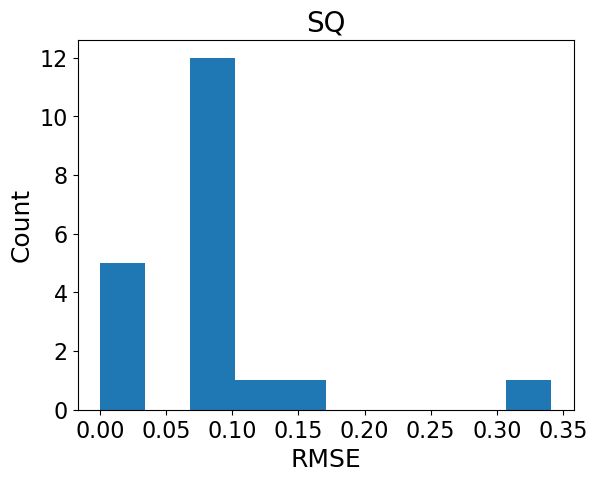

In [4]:
plt.hist(distance_sq)
plt.title("SQ", fontsize = 20)
plt.xlabel("RMSE", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
plt.savefig('Fig1_1.pdf', bbox_inches='tight', dpi=300)
distance_sq

[0.095309607094818,
 0.09578446980269782,
 0.0965337839362865,
 0.0952910032432192,
 0.09711437073286128,
 0.09232645685278015,
 0.09526813024877785,
 0.0957846080278494,
 0.09520026354246948,
 0.09566901865114197,
 0.08966385149904692,
 0.09567636589080657,
 0.09511466953116868,
 0.09655443824972239,
 0.09692664323019366,
 0.09519798969743311,
 0.0922870710363372,
 0.09533962407957097,
 0.1499641204421066,
 0.09476434679588724]

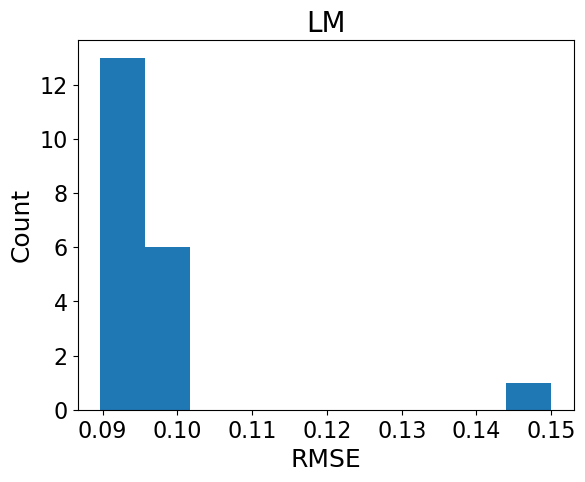

In [5]:
plt.hist(distance_lm)
plt.title("LM", fontsize = 20)
plt.xlabel("RMSE", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
plt.savefig('Fig1_2.pdf', bbox_inches='tight', dpi=300)
distance_lm

[0.29560001825792603,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.0944599691878494,
 0.32676859352511795,
 0.0944599691878494,
 0.0944599691878494]

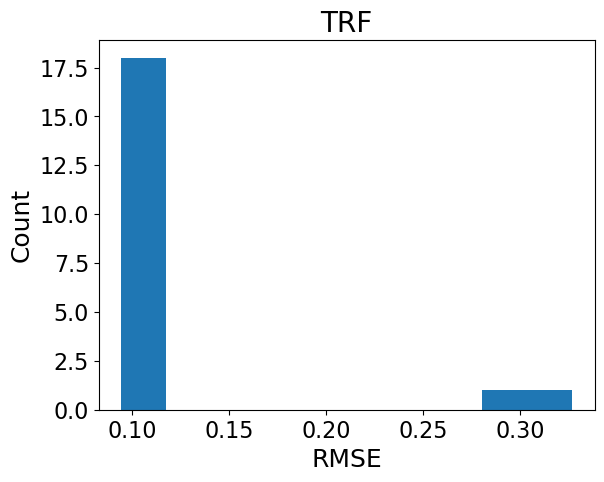

In [6]:
plt.hist(distance_trf)
plt.title("TRF", fontsize = 20)
plt.xlabel("RMSE", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
plt.savefig('Fig1_3.pdf', bbox_inches='tight', dpi=300)
distance_trf

In [7]:
dic_plot = {
    'Value': np.concatenate([distance_sq, distance_lm, distance_trf]),  # Combine both arrays into one column
    'Method': ['SQ'] * num_round + ['LM'] * num_round + ['TRF'] * num_round,      # Assign 'ilv' for first 20 rows, 'glv' for second 20 rows
}

data_plot = pd.DataFrame(dic_plot)

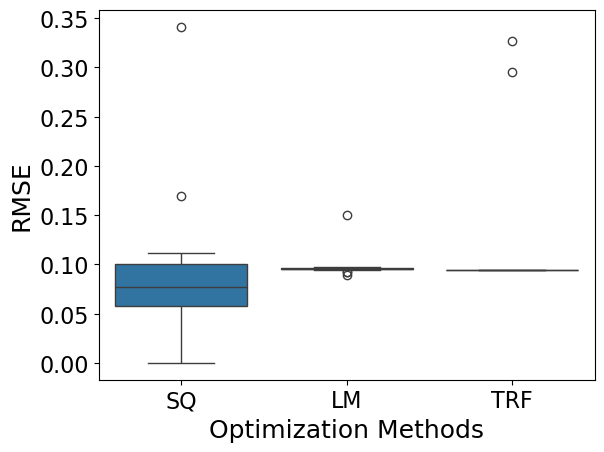

In [8]:
import seaborn as sns 
ax = sns.boxplot(x = data_plot['Method'], 
            y = data_plot['Value'], 
            hue = data_plot['Method'])

ax.tick_params(axis='x', labelsize=16)  # Change font size for x-axis tick labels
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel("Optimization Methods", fontsize=18)                  # Set x-axis label and size
ax.set_ylabel("RMSE", fontsize=18)                         # Set y-axis label and size

plt.savefig("different_optimization.jpg", dpi=300, bbox_inches="tight")


In [9]:
# Step 1: Perform the Friedman test
stat, p_value = friedmanchisquare(distance_sq, distance_lm, distance_trf)
print("Friedman test results:")
print(f"Statistic: {stat}, P-value: {p_value}")

# Step 2: Check significance of Friedman test
if p_value < 0.05:
    print("Significant differences detected. Proceeding with post-hoc pairwise comparisons...")

    # Step 3: Post-hoc pairwise comparisons using Wilcoxon signed-rank test
    pairwise_results = []
    comparisons = [
        ("distance_sq", "distance_lm", distance_sq, distance_lm),
        ("distance_sq", "distance_trf", distance_sq, distance_trf),
        ("distance_lm", "distance_trf", distance_lm, distance_trf)
    ]

    for name1, name2, group1, group2 in comparisons:
        stat, p = wilcoxon(group1, group2, alternative='less')  # Test for lower values
        pairwise_results.append((name1, name2, stat, p))

    # Step 4: Apply Bonferroni correction for multiple comparisons
    p_values = [result[3] for result in pairwise_results]
    corrected_p = multipletests(p_values, method="bonferroni")[1]

    # Step 5: Display results
    print("\nPairwise comparisons with Bonferroni correction:")
    for i, (name1, name2, stat, p) in enumerate(pairwise_results):
        print(f"{name1} vs {name2} -> Statistic: {stat}, Original P-value: {p}, Corrected P-value: {corrected_p[i]}")
else:
    print("No significant differences detected among the groups.")

Friedman test results:
Statistic: 2.700000000000017, P-value: 0.2592402606458893
No significant differences detected among the groups.
